# LaseNet Model Comparison: RNN vs. Transformer

This notebook trains and evaluates two architectures for latent variable estimation:
1.  **LaseNetRNN**: The original Bidirectional GRU model.
2.  **LaseNetTransformer**: An updated model using a Transformer encoder.

The workflow combines data loading, training, and evaluation into a single process for direct comparison of the two models.

## 1. Setup and Imports

In [22]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- Local Imports ---
# Ensure models.py and feature_utils.py are in the correct paths
from models import LaseNetRNN, LaseNetTransformer
from utils.feature_utils import (
    get_onehot_features,
    get_feature_list_by_model,
    get_labels_by_model,
    get_latent_labels,
    CognitiveModel
)

## 2. Configuration

In [23]:
# --- General Setup ---
RESULT_DIR = './results'
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
    
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# --- Data and Model Configuration ---
MODEL_TO_RUN = CognitiveModel.PRL4
DATA_FILE_PATH = f'../data/Combined_Simulations_Sampled.csv' # <-- SET YOUR DATA FILE PATH HERE
TARGET_VARIABLE = ['rpe_history'] # The latent variable you want to predict



Using device: cuda


## 3. Data Loading and Preprocessing

In [24]:
def get_raw_features(data, input_list, reshape=False):
    features = []

    if reshape:
        n_agent = len(data["agentid"].unique())
        n_trial = len(data["trials"].unique())

    for col in input_list:
        if col in data:
            raw_values = data[col].values.astype(np.float32)

            if reshape:
                if raw_values.shape[0] != n_agent * n_trial:
                    raise ValueError(f"Data shape {raw_values.shape[0]} does not match expected shape {n_agent * n_trial}.")
                try:
                    # Reshape to (n_agent, n_trial, 1)
                    raw_values = raw_values.reshape((n_agent, n_trial, 1))
                except Exception as e:
                    raise ValueError(f"Cannot reshape {len(raw_values)} values to shape ({n_agent}, {n_trial}, 1): {str(e)}")

            features.append(raw_values)

    # Stack along last axis → (n_agent, n_trial, n_features)
    output = np.concatenate(features, axis=-1 if reshape else 1)
    return output

feature_list = ["actions", "rewards"]
# Load data
original_data = pd.read_csv(DATA_FILE_PATH)
#original_data = original_data.iloc[:457 * 400]

# Agent-level split
unique_agents = data["agentid"].unique()
np.random.seed(33)
np.random.shuffle(unique_agents)

n_total = len(unique_agents)
n_test = n_val = int(n_total * 0.1)
n_train = n_total - n_val - n_test

train_agents = unique_agents[:n_train]
val_agents = unique_agents[n_train:n_train + n_val]
test_agents = unique_agents[n_train + n_val:]

train_data = data[data["agentid"].isin(train_agents)].sort_values(["agentid", "trials"])
val_data   = data[data["agentid"].isin(val_agents)].sort_values(["agentid", "trials"])
test_data  = data[data["agentid"].isin(test_agents)].sort_values(["agentid", "trials"])

# Extract features and labels using raw continuous data
X_train = get_raw_features(train_data, feature_list, reshape=True)
y_train = get_latent_labels(train_data, TARGET_VARIABLE)

X_val = get_raw_features(val_data, feature_list, reshape=True)
y_val = get_latent_labels(val_data, TARGET_VARIABLE)

X_test = get_raw_features(test_data, feature_list, reshape=True)
y_test = get_latent_labels(test_data, TARGET_VARIABLE)

# Final checks
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)
print("First 5 labels:", y_train[:5])
print(train_data.head(3))
print(X_train.shape)

Train: (4000, 377, 2) (4000, 377)
Val:   (500, 377, 2) (500, 377)
Test:  (500, 377, 2) (500, 377)
First 5 labels: [[0.30092636 0.41119903 0.44245437 ... 0.58913934 0.5672913  0.5497751 ]
 [0.29991397 0.3262408  0.33532202 ... 0.33845907 0.31796324 0.29631364]
 [0.2999725  0.3012875  0.37914857 ... 1.101216   1.0489514  0.98962545]
 [0.2996581  0.30693796 0.39926624 ... 1.0481527  0.9790873  0.9250793 ]
 [0.2998281  0.9016101  1.0241147  ... 0.56440926 0.5479069  0.5154098 ]]
     agentid   actions  correct_actions  rewards  isswitch  iscorrectaction  \
754        2 -4.794933              NaN     -3.6       NaN              NaN   
755        2 -5.047396              NaN     -3.6       NaN              NaN   
756        2 -5.183995              NaN     -3.6       NaN              NaN   

     trials  rpe_history  unchosen_rpe_history  alpha  beta  neg_alpha  \
754       1     0.300926              0.082368    NaN   NaN        NaN   
755       2     0.411199              0.091023    NaN  

## 4. Model Training

In [ ]:
dropout = 0.07 
dropout1 = 0.053 
dropout2 =  0.014 
# --- Training Hyperparameters ---
BATCH_SIZE = 128
LEARNING_RATE = 3e-4
EPOCHS = 400
EARLY_STOPPING_PATIENCE = 35

In [29]:
# Convert data to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# Create DataLoader for training
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

def train_model(model, model_name):
    """Generic training loop with a learning rate scheduler."""
    print(f"\n--- Training {model_name} Model ---")
    model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # --- LEARNING RATE SCHEDULER SETUP ---
    warmup_epochs = 5
    total_steps = len(train_loader) * EPOCHS
    
    def lr_lambda(current_step):
        # Linear warm-up for the first few epochs
        if current_step < len(train_loader) * warmup_epochs:
            return float(current_step) / (len(train_loader) * warmup_epochs)
        # Linear decay after warm-up
        return max(0.0, float(total_steps - current_step) / float(total_steps - len(train_loader) * warmup_epochs))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    # --- END SCHEDULER SETUP ---

    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    
    best_val_loss = float('inf')
    patience_counter = 0

    start_time = time.time()
    for epoch in tqdm(range(EPOCHS), desc=f'{model_name} Epochs'):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X_batch)
            
            if isinstance(outputs, dict):
                outputs = outputs['continuous_latent']

            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            # Step the scheduler after each batch
            scheduler.step()
            
            epoch_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_t.to(DEVICE))
            if isinstance(val_outputs, dict):
                val_outputs = val_outputs['continuous_latent']
            val_loss = criterion(val_outputs, y_val_t.to(DEVICE)).item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'{RESULT_DIR}/{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    end_time = time.time()
    print(f"Training finished in {end_time - start_time:.2f} seconds.")
    return history

In [30]:
# Initialize and train both models
feature_dim = X_train.shape[-1]
output_dim = 1

rnn_model = LaseNetRNN(feature_dim, continuous_output_dim=output_dim, dropout=dropout,
    dropout1=dropout1,
    dropout2=dropout2)
transformer_model = LaseNetTransformer(feature_dim, continuous_output_dim=output_dim)

rnn_history = train_model(rnn_model, 'RNN')
transformer_history = train_model(transformer_model, 'Transformer')


--- Training RNN Model ---


RNN Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Training finished in 455.80 seconds.

--- Training Transformer Model ---


Transformer Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping triggered at epoch 244
Training finished in 577.58 seconds.


## 5. Evaluation and Comparison

In [31]:
# Load best models for final evaluation
rnn_model.load_state_dict(torch.load(f'{RESULT_DIR}/RNN_best_model.pth'))
transformer_model.load_state_dict(torch.load(f'{RESULT_DIR}/Transformer_best_model.pth'))

rnn_model.to(DEVICE).eval()
transformer_model.to(DEVICE).eval()

# Make predictions on the test set
with torch.no_grad():
    y_pred_rnn = rnn_model(X_test_t.to(DEVICE)).cpu().numpy()
    y_pred_transformer = transformer_model(X_test_t.to(DEVICE)).cpu().numpy()

# Flatten results for metric calculations
y_test_flat = y_test.flatten()
y_pred_rnn_flat = y_pred_rnn.flatten()
y_pred_transformer_flat = y_pred_transformer.flatten()

# Calculate Metrics
mse_rnn = mean_squared_error(y_test_flat, y_pred_rnn_flat)
r2_rnn = r2_score(y_test_flat, y_pred_rnn_flat)

mse_transformer = mean_squared_error(y_test_flat, y_pred_transformer_flat)
r2_transformer = r2_score(y_test_flat, y_pred_transformer_flat)

print("--- Performance on Test Set ---")
print(f"RNN Model         -> MSE: {mse_rnn:.4f}, R-squared: {r2_rnn:.4f}")
print(f"Transformer Model -> MSE: {mse_transformer:.4f}, R-squared: {r2_transformer:.4f}")

--- Performance on Test Set ---
RNN Model         -> MSE: 1.6618, R-squared: 0.9546
Transformer Model -> MSE: 1.4944, R-squared: 0.9591


### Visual Comparison

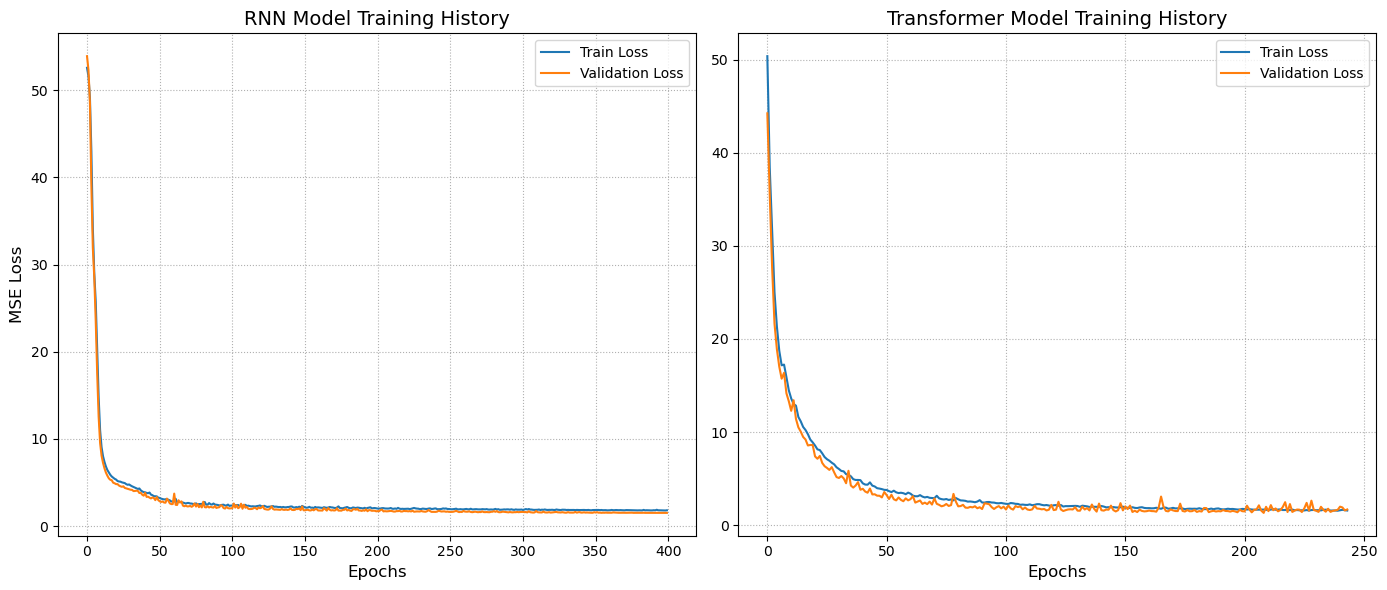

In [32]:
# 1. Plot Training History
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
rnn_hist_df = pd.DataFrame(rnn_history)
plt.plot(rnn_hist_df['train_loss'], label='Train Loss')
plt.plot(rnn_hist_df['val_loss'], label='Validation Loss')
plt.title('RNN Model Training History', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')

plt.subplot(1, 2, 2)
transformer_hist_df = pd.DataFrame(transformer_history)
plt.plot(transformer_hist_df['train_loss'], label='Train Loss')
plt.plot(transformer_hist_df['val_loss'], label='Validation Loss')
plt.title('Transformer Model Training History', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')

plt.tight_layout()
plt.savefig(f'{RESULT_DIR}/training_history_comparison.png')
plt.show()

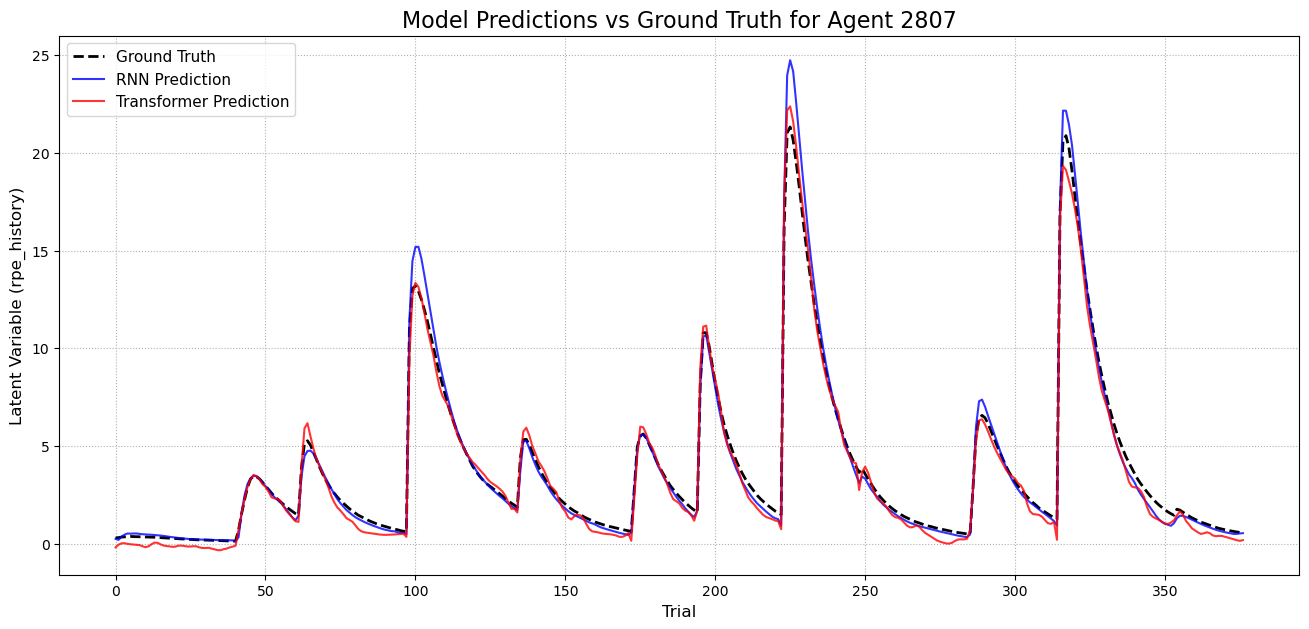

In [33]:
# 2. Plot Predictions vs. Actual for a sample agent
agent_idx_to_plot = 5
plt.figure(figsize=(16, 7))

plt.plot(y_test[agent_idx_to_plot, :], label='Ground Truth', color='black', linestyle='--', linewidth=2)
plt.plot(y_pred_rnn[agent_idx_to_plot, :], label=f'RNN Prediction', color='blue', alpha=0.8)
plt.plot(y_pred_transformer[agent_idx_to_plot, :], label=f'Transformer Prediction', color='red', alpha=0.8)

plt.title(f'Model Predictions vs Ground Truth for Agent {test_agents[agent_idx_to_plot]}', fontsize=16)
plt.xlabel('Trial', fontsize=12)
plt.ylabel(f'Latent Variable ({TARGET_VARIABLE[0]})', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle=':')
plt.savefig(f'{RESULT_DIR}/prediction_comparison_agent_{test_agents[agent_idx_to_plot]}.png')
plt.show()

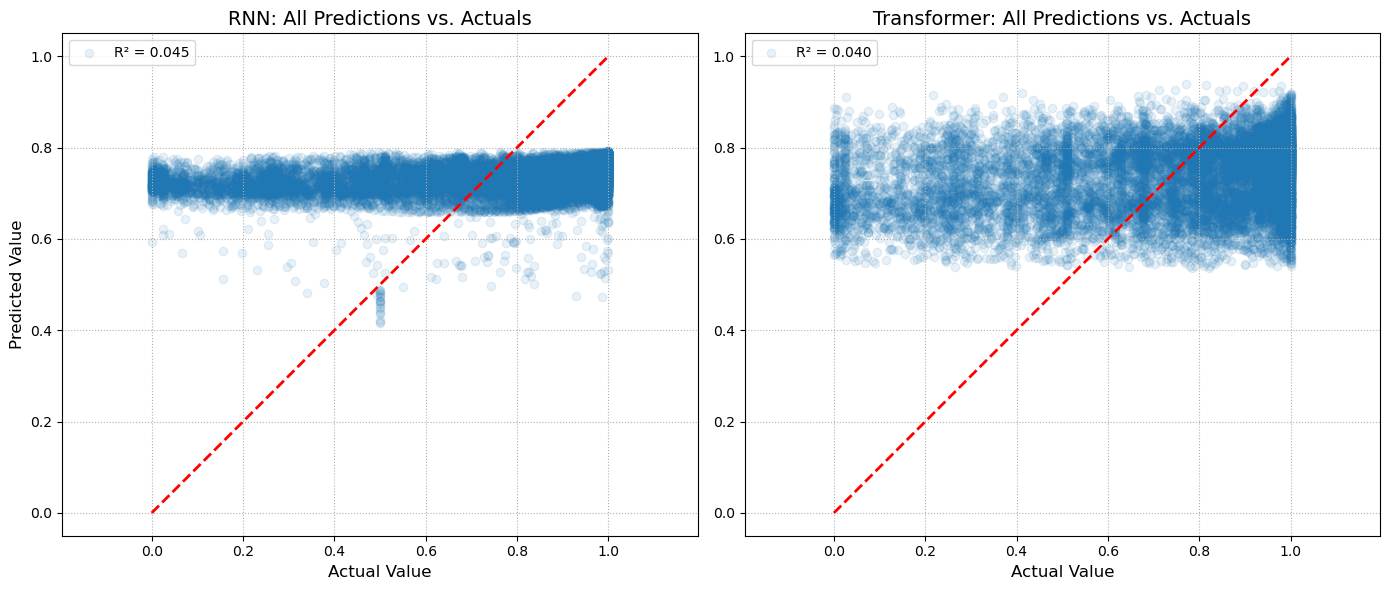

In [ ]:
# 3. Scatter plot of all test predictions vs actuals
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_flat, y_pred_rnn_flat, alpha=0.1, label=f'R² = {r2_rnn:.3f}')
plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], 'r--', linewidth=2)
plt.title('RNN: All Predictions vs. Actuals', fontsize=14)
plt.xlabel('Actual Value', fontsize=12)
plt.ylabel('Predicted Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(y_test_flat, y_pred_transformer_flat, alpha=0.1, label=f'R² = {r2_transformer:.3f}')
plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], 'r--', linewidth=2)
plt.title('Transformer: All Predictions vs. Actuals', fontsize=14)
plt.xlabel('Actual Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')
plt.axis('equal')
plt.tight_layout()
plt.savefig(f'{RESULT_DIR}/scatter_comparison.png')
plt.show()